# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

# 1. 导入相关库

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import avg, col, concat, desc, asc, explode, lit, split, udf, count, isnan, countDistinct
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml.feature import CountVectorizer, VectorAssembler, IDF, RegexTokenizer, PCA, Normalizer, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import re

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .appName('Sparkify') \
    .getOrCreate()

# 2. 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

## 2.1 加载数据和初步查看数据

In [3]:
# 加载数据
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# 查看数据的总行数
df.count()

286500

In [5]:
# 查看数据的总列数
len(df.columns)

18

In [6]:
# 查看数据的shema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.show(5, truncate=False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logg

总结以上初步查看数据的结果：

1. 数据总大小：
$ 286500 \times 18$

2. 总结初步查看数据后，按照数值型数据和类别型数据给出每列数据的含义：
    - 数值型数据：
        - userId(string): 用户ID
        - ts(long): 记录时间的timestamp
        - sessionId(long): 每次打开app创建一个sessionId
        - length(double): 歌的长度
        - itemInSession(long): Session中的项目数量
        - registration(long): 注册时间timestamp
    - 类别型数据：
        - artist(string): 艺术家
        - auth(string): 用户身份验证状态，比如Logged In状态
        - firstName(string): 用户的名字
        - gender(string): 用户性别
        - lastName(string): 用户的姓
        - level(string): 有free和paid两种
        - location(string): 用户的定位
        - method(string): HTTP请求方式，PUT和GET两种
        - page(string): 页面名称，Home, Upgrade, Downgrade等
        - song(string): 歌曲名称
        - status(long): 请求状态，200、307、404这三种
        - userAgent(string): 用户浏览器
        

## 2.2 清洗数据

缺失值存在三种情况：1. NaN，Not A Number；2. NULL，空值；3. '', 空字符串。

在处理需要注意上述三种情况都可以视为存在缺失值，情况1和2的缺失值在pyspark中的查找方法参照[stackoverflow问题: Differences between null and NaN in spark](https://stackoverflow.com/questions/43882699/differences-between-null-and-nan-in-spark-how-to-deal-with-it), 情况3可以直接使用等式查找。

In [8]:
# 存放有缺失值的列
columns_with_missing = {}
# 获取所有列名称
df_column_items = df.columns
for column in df_column_items:
    missing_count = df.filter(isnan(df[column]) | df[column].isNull() | (df[column] == "")).count()
    if  missing_count:
        columns_with_missing[column] = missing_count
# 打印存在缺失值的列
print('存在缺失值的列和缺失值数量: ')
for column, missing_count in columns_with_missing.items():
    print('{:<{}}{:>{}}'.format(column, 12, missing_count, 10))

存在缺失值的列和缺失值数量: 
artist           58392
firstName         8346
gender            8346
lastName          8346
length           58392
location          8346
registration      8346
song             58392
userAgent         8346
userId            8346


可以看到，userId、firstName、gender、lastName、location、registration、userAgent列的缺失值数量是相同的，他们是否有关系呢？

可以看出上述特征都是用户的信息，而另外的三个缺失值数量为58392的特征为歌曲相关的信息。

接下来可以先对最重要的userId特征的缺失值进行处理，再进一步分析。

In [9]:
# 查看userId列的为NULL数量
df.filter(df.userId.isNull()).select("userId").count()

0

In [10]:
# 查看userId列的为NAN数量
df.filter(isnan(df.userId)).select("userId").count()

0

In [11]:
# 查看userId列的为空字符串的数量
df.filter(df.userId == "").select("userId").count()

8346

可以看出userId列的缺失值，全部是为空字符串这种情况，那么进一步删除userId列的空字符串行

In [12]:
# 删除userId列的无效空字符串行
df = df.filter("userId != ''")
df.count()

278154

In [13]:
# 删除userId列缺失值行后，查看仍然存在缺失值的列
# 存放有缺失值的列
columns_with_missing = {}
# 获取所有列名称
df_column_items = df.columns
for column in df_column_items:
    missing_count = df.filter(isnan(df[column]) | df[column].isNull() | (df[column] == "")).count()
    if  missing_count:
        columns_with_missing[column] = missing_count
# 打印存在缺失值的列
print('存在缺失值的列和缺失值数量: ')
for column, missing_count in columns_with_missing.items():
    print('{:<{}}{:>{}}'.format(column, 12, missing_count, 10))

存在缺失值的列和缺失值数量: 
artist           50046
length           50046
song             50046


可以看出删除userId的缺失值后，关于用户信息的firstName、gender、lastName、location、registration、userAgent这些特征的缺失值也没有了，所以关于用户信息的上述列是同时存在缺失值的，而这些存在缺失值的数据很有可能是关于未注册用户的

In [14]:
# 查看artist列的为NULL数量
df.filter(df.artist.isNull()).select("artist").count()

50046

In [15]:
# 查看artist列和length列是否同时缺失值
df_inter = df.filter(df.artist.isNull()).select("length")
df_inter.filter(df_inter['length'].isNull()).select("length").count()

50046

In [16]:
# 查看artist列和song是否同时缺失值
df_inter = df.filter(df.artist.isNull()).select("song")
df_inter.filter(df_inter['song'].isNull()).select("song").count()

50046

可以看出，artist, song, length这三个关于歌曲信息的特征是同时缺失的

In [17]:
# 打印出artist缺失值所在行
df.filter(df.artist.isNull()).select(["artist", "userId", "method", "page"]).show()

+------+------+------+---------------+
|artist|userId|method|           page|
+------+------+------+---------------+
|  null|    30|   PUT|Add to Playlist|
|  null|     9|   GET|    Roll Advert|
|  null|     9|   PUT|      Thumbs Up|
|  null|    54|   GET|      Downgrade|
|  null|    54|   PUT|      Thumbs Up|
|  null|     9|   PUT|    Thumbs Down|
|  null|     9|   GET|           Home|
|  null|     9|   PUT|         Logout|
|  null|    74|   PUT|      Thumbs Up|
|  null|     9|   GET|           Home|
|  null|    30|   PUT|    Thumbs Down|
|  null|     4|   PUT|         Logout|
|  null|     4|   GET|           Home|
|  null|    74|   PUT|Add to Playlist|
|  null|     4|   GET|           Home|
|  null|    74|   PUT|      Thumbs Up|
|  null|     9|   PUT|      Thumbs Up|
|  null|    30|   PUT|      Thumbs Up|
|  null|    74|   PUT|      Thumbs Up|
|  null|    30|   PUT|      Thumbs Up|
+------+------+------+---------------+
only showing top 20 rows



In [18]:
# 打印出artist存在缺失值的userId
df.filter(df.artist.isNull()).select("userId").dropDuplicates().show()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



可以看到，删除userId特征缺失值的行，和userId特征缺失数量相同的特征不再具有缺失值了。

对于剩余三列仍然有缺失值的情况，我们这里暂不处理，因为歌曲信息的缺失值对接下来的分析影响小一些，而且缺失值数量较大，先选择不删除更加稳妥。

# 3. 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

## 3.1 定义客户流失数据

In [19]:
# 定义客户流失列
flag_churned = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', flag_churned('page'))

In [20]:
# 查看dataframe的各列
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



建立phase变量，该变量只有0和1两个取值，1表示用户已经进入过了Cancelation Confirmation页面，0表示未进入Cancelation Confirmation页面。

通过该变量可以很好的理解何谓“Cancellation Confirmation”页面，何谓流失用户

In [21]:
# 窗口函数，用于区分流失用户和留存用户
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# 创建phase特征，0-用户为留存状态，1-用户已经流失
df_phase = df.withColumn("phase", Fmax("churn").over(windowval))

In [22]:
# 查看用户进入该页面的次数排行
df_phase.groupBy("userId").agg({"phase": "sum"}).orderBy(desc("sum(phase)")).show()

+------+----------+
|userId|sum(phase)|
+------+----------+
|   125|         2|
|100007|         1|
|300007|         1|
|    17|         1|
|    28|         1|
|100025|         1|
|    18|         1|
|100005|         1|
|    87|         1|
|     3|         1|
|100022|         1|
|100014|         1|
|100006|         1|
|   101|         1|
|    70|         1|
|    54|         1|
|    73|         1|
|    29|         1|
|100021|         1|
|    51|         1|
+------+----------+
only showing top 20 rows



可以看出，Cancellation Confirmation页面为用户取消确认的最终页面，之后用户不再访问，那么该用户就是所谓的流失用户。

但是有一个例外的用户，这个用户就是ID为125的用户，在确认取消页面后居然再次有交互页面。

接下来查看该用户为什么会出现这种情况。

In [23]:
# 按时间逆序查看ID为125的用户的情况
df_phase.where(df["userId"] == 125).select(["userId", "song", "ts", "length", "page", "churn", "phase"]).orderBy(desc("ts")).collect()

[Row(userId='125', song=None, ts=1539318918000, length=None, page='Cancel', churn=0, phase=1),
 Row(userId='125', song=None, ts=1539318918000, length=None, page='Cancellation Confirmation', churn=1, phase=1),
 Row(userId='125', song=None, ts=1539318917000, length=None, page='Roll Advert', churn=0, phase=0),
 Row(userId='125', song='Kota', ts=1539318906000, length=323.81342, page='NextSong', churn=0, phase=0),
 Row(userId='125', song="They're Red Hot", ts=1539318728000, length=178.41587, page='NextSong', churn=0, phase=0),
 Row(userId='125', song="Don't Leave Me Behind", ts=1539318515000, length=213.60281, page='NextSong', churn=0, phase=0),
 Row(userId='125', song='Love You Down', ts=1539318124000, length=391.26159, page='NextSong', churn=0, phase=0),
 Row(userId='125', song='Leader Of Men (Album Version)', ts=1539317914000, length=210.83383, page='NextSong', churn=0, phase=0),
 Row(userId='125', song="I'm On My Way", ts=1539317711000, length=203.2322, page='NextSong', churn=0, phase=0

In [24]:
# 按时间逆序查看ID为100007的用户的情况
df_phase.where(df["userId"] == 100007).select(["userId", "song", "ts", "length", "page", "churn", "phase"]).orderBy(desc("ts")).collect()

[Row(userId='100007', song=None, ts=1543491909000, length=None, page='Cancellation Confirmation', churn=1, phase=1),
 Row(userId='100007', song=None, ts=1543491907000, length=None, page='Cancel', churn=0, phase=0),
 Row(userId='100007', song=None, ts=1543491906000, length=None, page='Downgrade', churn=0, phase=0),
 Row(userId='100007', song='Bonkers', ts=1543491877000, length=176.87465, page='NextSong', churn=0, phase=0),
 Row(userId='100007', song='Mercy:The Laundromat', ts=1543491778000, length=99.16036, page='NextSong', churn=0, phase=0),
 Row(userId='100007', song=None, ts=1543491582000, length=None, page='Thumbs Down', churn=0, phase=0),
 Row(userId='100007', song='God Save The Queen', ts=1543491581000, length=197.82485, page='NextSong', churn=0, phase=0),
 Row(userId='100007', song='Here (In Your Arms) (Radio Edit)', ts=1543491363000, length=218.38322, page='NextSong', churn=0, phase=0),
 Row(userId='100007', song=None, ts=1543491145000, length=None, page='Thumbs Up', churn=0, ph

可以发现，用户125是因为取消页面和确认取消页面的timestamp完全相同，从而导致window窗求和时把取消页面排在了确认取消页面的后面。

## 3.2 探索单个变量

查看每列数据的类型和取值情况，对于类别型数据和离散数值型数据可以绘制柱状图查看分布情况，对于连续数值型数据可以绘制分布直方图查看分布情况，接下来对各列的变量进行探索分析。

In [25]:
# 查看流失用户数量及占总用户量的百分比
cancelled_rate = df.groupBy('userId').sum().select(avg('sum(churn)')).collect()[0][0]
print('流失用户占总用户量的百分比: {:.2f}%'.format(cancelled_rate * 100))

流失用户占总用户量的百分比: 23.11%


In [26]:
# 查看艺术家数量
artist_num = df.select('artist').distinct().count()
print('艺术家的数量：{}'.format(artist_num))

艺术家的数量：17656


In [27]:
# 查看歌曲数量
song_num = df.select('song').distinct().count()
print('歌曲的数量：{}'.format(song_num))

歌曲的数量：58481


In [28]:
# 查看艺术家被浏览的排行
df.groupBy('artist') \
    .agg({'artist': 'count'}) \
    .withColumnRenamed('count(artist)', 'artist_count') \
    .orderBy('artist_count', ascending=0).show()

+--------------------+------------+
|              artist|artist_count|
+--------------------+------------+
|       Kings Of Leon|        1841|
|            Coldplay|        1813|
|Florence + The Ma...|        1236|
|       Dwight Yoakam|        1135|
|            BjÃÂ¶rk|        1133|
|      The Black Keys|        1125|
|                Muse|        1090|
|       Justin Bieber|        1044|
|        Jack Johnson|        1007|
|              Eminem|         953|
|           Radiohead|         884|
|     Alliance Ethnik|         876|
|               Train|         854|
|        Taylor Swift|         840|
|         OneRepublic|         828|
|         The Killers|         822|
|         Linkin Park|         787|
|         Evanescence|         781|
|            Harmonia|         729|
|       Guns N' Roses|         713|
+--------------------+------------+
only showing top 20 rows



可以看出，播放量最高的艺术家是Kings Of Leon

In [29]:
# 查看歌曲播放的排行
df.groupBy('song') \
    .agg({'song': 'count'}) \
    .withColumnRenamed('count(song)', 'song_count') \
    .orderBy('song_count', ascending=0).show()

+--------------------+----------+
|                song|song_count|
+--------------------+----------+
|      You're The One|      1153|
|                Undo|      1026|
|             Revelry|       854|
|       Sehr kosmisch|       728|
|Horn Concerto No....|       641|
|Dog Days Are Over...|       574|
|             Secrets|       466|
|        Use Somebody|       459|
|              Canada|       435|
|             Invalid|       424|
|    Ain't Misbehavin|       409|
|       ReprÃÂ©sente|       393|
|SinceritÃÂ© Et J...|       384|
|Catch You Baby (S...|       373|
|              Yellow|       343|
|    Somebody To Love|       343|
|    Hey_ Soul Sister|       334|
|            The Gift|       327|
|           Fireflies|       312|
|          Love Story|       309|
+--------------------+----------+
only showing top 20 rows



In [30]:
# 查看用户登陆状态的取值
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [31]:
#查看用户登录状态的分布
df.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



大多数时候处于登陆状态，取消状态占比很低

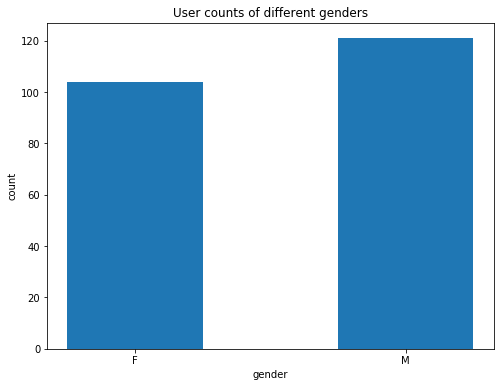

In [32]:
#绘制用户性别的柱状图
gender_info = df.groupBy('userId','gender').count().select(['userId', 'gender']).groupBy('gender').count().collect()
gender_vals = []
gender_cnts = []
for gender_val, gender_cnt in gender_info:
    gender_vals.append(gender_val)
    gender_cnts.append(gender_cnt)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(gender_vals)), gender_cnts, width=0.5, tick_label=gender_vals)
ax.set_title('User counts of different genders')
ax.set_xlabel('gender')
ax.set_ylabel('count')
plt.show()

男性用户略多于女性用户

In [33]:
#查看first name
df.groupBy('firstName').count().orderBy('count', ascending=False).show()

+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 9632|
|    Riley| 7970|
|   Lucero| 6880|
|   Emilia| 5732|
|     Emma| 5478|
|   Joseph| 5209|
|    Colin| 4989|
|   Nicole| 4825|
|   Joshua| 4654|
|  Brayden| 4621|
|  Alyssia| 4428|
|   Jayden| 4268|
|   Dillyn| 4257|
|   Sophia| 4246|
|   Bryson| 4172|
|  Katiana| 3769|
|   Oliver| 3657|
|    Kaleb| 3603|
|   Samuel| 3486|
|    Alexi| 3437|
+---------+-----+
only showing top 20 rows



In [34]:
#查看last name
df.groupBy('lastName').count().orderBy('count', ascending=False).show()

+----------+-----+
|  lastName|count|
+----------+-----+
|  Campbell|14060|
|      Reed| 9284|
|  Williams| 8410|
|    Taylor| 7230|
|   Johnson| 6106|
|    Larson| 6105|
|     House| 5732|
|  Thompson| 5217|
|     Jones| 4831|
|      Beck| 4825|
|     Allen| 4659|
|   Stewart| 4461|
|    Miller| 4428|
|    Thomas| 4370|
|Richardson| 4257|
|  Phillips| 4002|
|  Robinson| 3890|
|   Daniels| 3769|
|  Roberson| 3761|
|      Long| 3483|
+----------+-----+
only showing top 20 rows



In [35]:
# 查看itemsession的描述统计量
df.select('itemInSession').describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [36]:
# 查看itemsession的取值个数
df.select('itemInSession').dropDuplicates().count()

1311

In [37]:
# 查看歌曲长度的描述统计量
df.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [38]:
# 查看用户级别的取值
df.groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



大部分为付费状态下和软件进行交互

In [39]:
# 查看用户交互时位置的取值
df.groupBy('location').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|30131|
|New York-Newark-J...|23684|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 9499|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7605|
|Louisville/Jeffer...| 6880|
|Philadelphia-Camd...| 5890|
|Chicago-Napervill...| 5114|
|    St. Louis, MO-IL| 4858|
|Phoenix-Mesa-Scot...| 4846|
|Vineland-Bridgeto...| 4825|
|          Wilson, NC| 4659|
|Denver-Aurora-Lak...| 4453|
|           Ionia, MI| 4428|
|San Antonio-New B...| 4373|
|        Danville, VA| 4257|
|Atlanta-Sandy Spr...| 4236|
|New Haven-Milford...| 4007|
|         Jackson, MS| 3839|
+--------------------+-----+
only showing top 20 rows



软件使用量排名最高的三个城市分别是：洛杉矶、纽约和波士顿。

In [40]:
# 查看用户请求方式的取值
df.groupBy('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



In [41]:
# 查看网页属性
df.groupBy('page').count().orderBy('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



访问最多的页面是Next Song页面，其次是Thumbs Up点赞页面，再次是Home页面及主页。

In [42]:
# 查看请求注册状态的描述统计量
df.select('registration').describe().show()

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+



In [43]:
# 查看请SessionId的取值
df.groupBy('sessionId').count().orderBy('count', ascending=False).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     1840| 1282|
|      316| 1223|
|      236|  873|
|      635|  855|
|      368|  777|
|      731|  758|
|       76|  754|
|      123|  751|
|      436|  742|
|      344|  708|
|     2305|  699|
|      827|  695|
|      377|  689|
|        1|  680|
|     2056|  668|
|      132|  668|
|     1483|  656|
|      479|  651|
|     1150|  642|
|      529|  637|
+---------+-----+
only showing top 20 rows



In [44]:
# 查看请求返回状态的取值
df.groupBy('status').count().sort(desc("count")).show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



- 200: 请求成功
- 307: 临时重定向
- 404: 服务器无法根据客户端的请求找到资源（网页）

200和307均可以返回页面，能返回正确页面的请求状态占大多数，只有极少数时候不能返回请求资源。

In [45]:
# 查看时间戳的取值
df.select('ts').describe().show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [46]:
# 查看本数据集的时间范围
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
start_time = df.select("ts").withColumn("datetime", get_datetime("ts")).sort(asc("datetime")).select("datetime").take(1)[0][0]
stop_time = df.select("ts").withColumn("datetime", get_datetime("ts")).sort(desc("datetime")).select("datetime").take(1)[0][0]
print("本数据集的采集的时间范围是{}至{}".format(start_time, stop_time))

本数据集的采集的时间范围是2018-10-01 00:01:57至2018-12-03 01:11:16


In [47]:
# 查看userAgent的取值
df.select('userAgent').dropDuplicates().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [48]:
# 查看用户的数量
df.select('userId').dropDuplicates().count()

225

In [49]:
# 查看用户的交互次数排行
df.groupBy('userId').count().orderBy('count', ascending=False).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
|    74| 2887|
+------+-----+
only showing top 20 rows



总共有225个用户，在该软件上交互次数最多的用户ID为39.

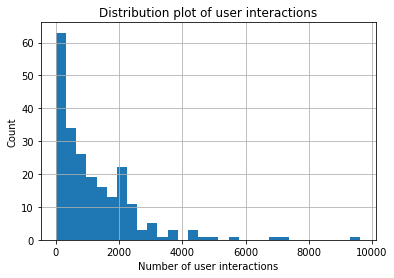

In [50]:
# 绘图查看用户的交互数量分布情况
pd_users = df.groupBy('userId').count().toPandas()
pd_users['count'].hist(bins=30)
plt.xlabel("Number of user interactions")
plt.ylabel("Count")
plt.title("Distribution plot of user interactions")
plt.show()

可以看出，用户的交互次数为长尾分布，大多数用户的交互次数在2000次以下，只有少部分用户的交互次数很高。

In [51]:
# 查看用户打开app的次数排行
df.groupBy('userId').agg(countDistinct(col("sessionId")).alias("session_counts")).orderBy(desc("session_counts")).show()

+------+--------------+
|userId|session_counts|
+------+--------------+
|    39|           107|
|    92|            86|
|200023|            76|
|300011|            76|
|   140|            71|
|300017|            63|
|300021|            58|
|    42|            47|
|    85|            41|
|    35|            38|
|    54|            37|
|200020|            36|
|   100|            35|
|    29|            34|
|300015|            33|
|    95|            33|
|    13|            33|
|    30|            32|
|     9|            31|
|   126|            30|
+------+--------------+
only showing top 20 rows



同样是ID为39的用户打开app的次数最多

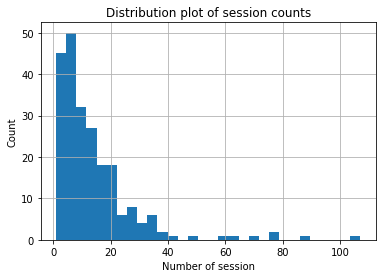

In [52]:
# 绘图查看用户打开app次数的分布情况
pd_users = df.groupBy('userId').agg(countDistinct(col("sessionId")).alias("session_counts")).toPandas()
pd_users['session_counts'].hist(bins=30)
plt.xlabel("Number of session")
plt.ylabel("Count")
plt.title("Distribution plot of session counts")
plt.show()

## 3.3 探索多个变量

主要探索Churn列和其他列的相关关系，以便初步观察留存用户和流失用户之间的差异和练习。

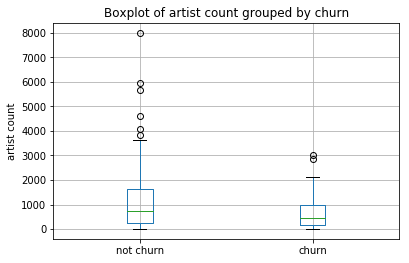

In [53]:
# 探索听歌曲的artist数量和用户是否流失的关系
# 获取用户听歌的artist数量的dataframe
df_artist = df.groupBy(["userId"])\
    .agg({"churn": "sum", "artist": "count"})\
    .withColumnRenamed("sum(churn)", "churn")\
    .withColumnRenamed("count(artist)", "artist_count").toPandas()
# 根据churn画出artist数量的箱线图
df_artist.boxplot(column="artist_count", by="churn")
plt.title("Boxplot of artist count grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("artist count")
plt.show()

流失用户听歌的artist数量整体上更少，中位数、最大值均相对偏低。

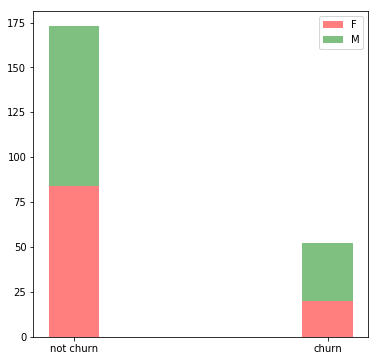

In [54]:
# 探索不同性别和用户是否流失的关系
# 获取按照用户ID和性别分组的流失数据框
df_gender = df.groupBy(["userId", "gender"]).agg({"churn": "sum"}).withColumnRenamed("sum(churn)", "churn")
# 获取性别列表和流失与否列表
genders = df_gender.select("gender").dropDuplicates().collect()
churns = df_gender.select("churn").dropDuplicates().collect()
# 创建churn对应的list以便
churns_dict = {0: "not churn", 1: "churn"}
churns_str = []
for churn in churns:
    churns_str.append(churns_dict[churn[0]])
# 创建按gender为行标，churn为列标的用户数量数据
users_genders_churns = []
for gender in genders:
    gender = gender[0]
    temp = []
    for churn in churns:
        churn = churn[0]
        users_count = df_gender.filter((df_gender["gender"] == gender) & (df_gender["churn"] == churn)).count()
        temp.append(users_count)
    users_genders_churns.append(temp)
# 根据churn画出性别分布的柱状图
fig = plt.figure("Barplot of user counts in different gender grouped by churn", figsize=(6,6))
ax = fig.add_subplot(111)
colors = ['r', 'g']
x_axis = np.arange(len(users_genders_churns[0]))
for i in range(len(users_genders_churns)):
    ax.bar(x_axis, users_genders_churns[i], width=0.2, 
           bottom=np.sum(users_genders_churns[:i], axis=0), 
           color=colors[i], alpha=0.5, label=genders[i][0])
plt.legend()
plt.xticks(x_axis, churns_str)
plt.show()

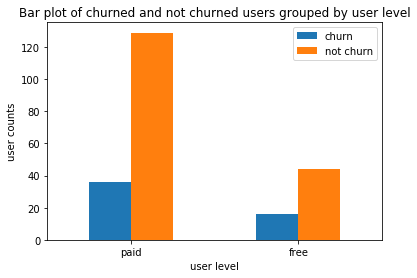

In [55]:
# 绘制付费与否和是否流失的关系
# 创建paid列，1表示付费，0表示免费
flag_paid = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
# 在创建paid列时，只要用户付费过一次就认为用户为付费用户
df_level = df.withColumn("paid", flag_paid("level")).select(["userId", "paid", "churn"]) \
    .groupBy("userId").agg({"paid": "sum", "churn": "sum"}) \
    .withColumnRenamed("sum(paid)", "paid_int").withColumnRenamed("sum(churn)", "churn_int")
# 将0-1类型的类别数据paid,churn列转换为string类型
paid_to_str = udf(lambda x: "paid" if x >= 1 else "free", StringType())
churn_to_str = udf(lambda x: "churn" if x >= 1 else "not churn", StringType())
df_level = df_level.withColumn("level", paid_to_str("paid_int")).withColumn("churn_str", churn_to_str("churn_int"))
# 创建绘图的数据框
level_str = ["paid", "free"]
churn_str = ["churn", "not churn"]
counts_level_churn = []
for level in level_str:
    temp = []
    for churn in churn_str:
        temp.append(df_level.filter((df_level.level == level) & (df_level.churn_str == churn)).count())
    counts_level_churn.append(temp)
pd_level_churn = pd.DataFrame(counts_level_churn, index=level_str, columns=churn_str)
# 绘制付费用户的流失柱状图和免费用户的流失柱状图
pd_level_churn.plot.bar(rot=0)
plt.title("Bar plot of churned and not churned users grouped by user level")
plt.ylabel("user counts")
plt.xlabel("user level")
plt.show()

可以看出，付过费的用户流失率略低，说明付过费的用户更认可该产品，也可能是因为产品得到了认可才付费的。

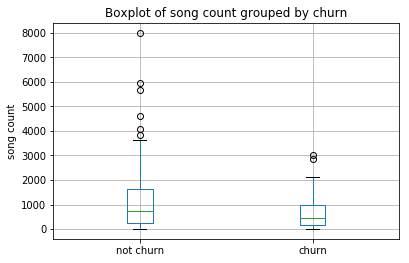

In [56]:
# 绘制听歌数量和用户流失的关系，通过箱线图展现
# 这里采用page特征的取值NextSong表示听歌一次
# 获取用户听歌数量的数据框
flag_next_song = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
df_songs = df.withColumn("NextSong", flag_next_song("page")).select(["userId", "NextSong", "churn"]) \
    .groupBy("userId").agg({"NextSong": "sum", "churn": "sum"}) \
    .withColumnRenamed("sum(NextSong)", "song_count") \
    .withColumnRenamed("sum(churn)", "churn").toPandas()
# 根据churn画出听歌数量的箱线图
df_songs.boxplot(column="song_count", by="churn")
plt.title("Boxplot of song count grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("song count")
plt.show()

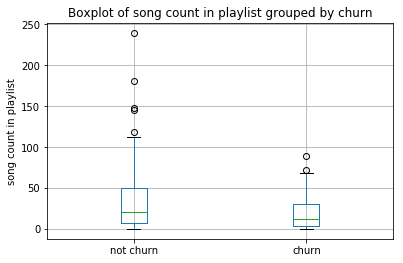

In [57]:
# 绘制Add to Playlist的歌曲数量和用户流失的关系，通过箱线图展现
# 这里采用page特征的取值Add to Playlist表示收藏一首歌曲
# 获取收藏歌曲数量的数据框
flag_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
df_playlist = df.withColumn("playlist", flag_playlist("page")).select(["userId", "playlist", "churn"]) \
    .groupBy("userId").agg({"playlist": "sum", "churn": "sum"}) \
    .withColumnRenamed("sum(playlist)", "playlist_songs") \
    .withColumnRenamed("sum(churn)", "churn").toPandas()
# 根据churn画出收藏歌曲数量的箱线图
df_playlist.boxplot(column="playlist_songs", by="churn")
plt.title("Boxplot of song count in playlist grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("song count in playlist")
plt.show()

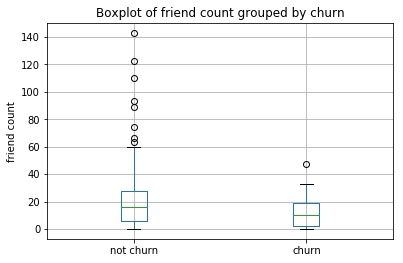

In [58]:
# 绘制Add friend页面点击次数和用户流失的关系，通过箱线图展现
# 这里认为点击一次Add friend为添加一次朋友，看看是不是经常添加朋友的用户流失可能性更小
# 获取添加朋友数量的数据框
flag_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
df_friend = df.withColumn("friend", flag_friend("page")).select(["userId", "friend", "churn"]) \
    .groupBy("userId").agg({"friend": "sum", "churn": "sum"}) \
    .withColumnRenamed("sum(friend)", "friend_count") \
    .withColumnRenamed("sum(churn)", "churn").toPandas()
# 根据churn画出收藏歌曲数量的箱线图
df_friend.boxplot(column="friend_count", by="churn")
plt.title("Boxplot of friend count grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("friend count")
plt.show()

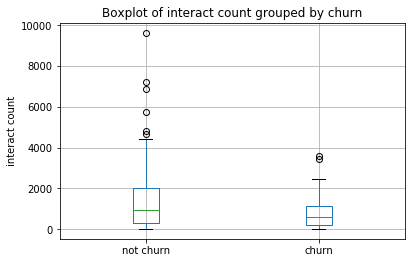

In [59]:
# 绘制用户交互次数和用户流失的关系，通过箱线图展现
# 这里认为用户的每一次操作就是一次交互，观察是否交互多的用户流失率更低
# 获取用户交互数量的数据框
df_interact = df.groupBy("userId").agg({"userId": "count", "churn": "sum"}) \
    .withColumnRenamed("count(userId)", "interact_count") \
    .withColumnRenamed("sum(churn)", "churn").toPandas()
# 根据churn画出收藏歌曲数量的箱线图
df_interact.boxplot(column="interact_count", by="churn")
plt.title("Boxplot of interact count grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("interact count")
plt.show()

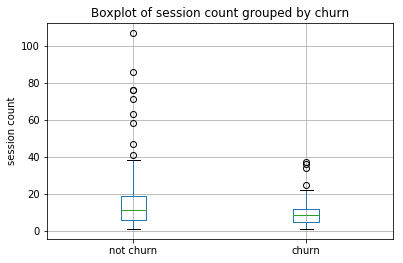

In [60]:
# 绘制打开app次数和用户流失的关系，通过箱线图展现
# 这里认为产生一个sessionId就是打开一次app，观察是否打开挨app次数多的用户流失率更低
# 获取打开app次数的数据框
df_session = df.groupBy("userId").agg(countDistinct("sessionId").alias("session_count"), Fsum("churn").alias("churn")).toPandas()
# 根据churn画出打开app数量的箱线图
df_session.boxplot(column="session_count", by="churn")
plt.title("Boxplot of session count grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("session count")
plt.show()

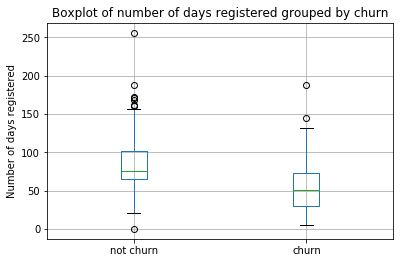

In [61]:
# 绘制注册天数和用户流失的关系，通过箱线图展现
# 这里认为注册天数就是用户最后一次在app的记录，到注册时的天数
get_regDay = udf(lambda x, y: int((x - y)/(1000*60*60*24)), IntegerType())
df_reg = df.withColumn("regDay", get_regDay(df.ts, df.registration)).select(["userId", "regDay", "churn"])\
    .groupBy("userId").agg(Fmax("regDay").alias("regDay"), Fsum("churn").alias("churn")).toPandas()
# 根据churn画出收藏歌曲数量的箱线图
df_reg.boxplot(column="regDay", by="churn")
plt.title("Boxplot of number of days registered grouped by churn")
plt.suptitle('')
plt.xticks([1, 2], ["not churn", "churn"])
plt.xlabel("")
plt.ylabel("Number of days registered")
plt.show()

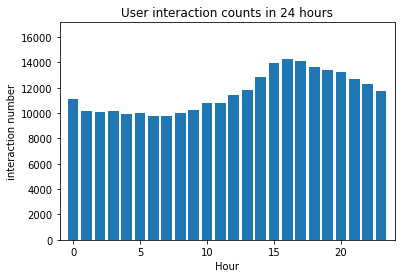

In [62]:
# 按小时统计交互次数
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_hour = df.withColumn("hour", get_hour(df.ts))
interact_in_hour_pd = df_hour.groupBy("hour").count().orderBy(df_hour["hour"].cast("float")).toPandas()
# 绘出按时间统计的用户交互次数
plt.bar(interact_in_hour_pd["hour"].astype(int), interact_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * max(interact_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("interaction number")
plt.title("User interaction counts in 24 hours");

探索性数据分析的总结：
- 定义客户流失的数据
    - 定义churn列，1表示用户点击了"Cancellation Confirmation"页面。
    - 定义phase列，通过定义该列理解了何谓“确认取消”页面，何谓流失用户：即离开Sparkify，并且没有返回。
- 探索单个变量
    - 本数据集总共有225个独立的用户，流失的用户占比为23.11%
    - 本数据集中在该软件上交互次数最多的用户ID为39
    - 本数据集中用户的交互次数为长尾分布，大多数用户的交互次数在2000次以下
    - 本数据集包含的艺术家数量为17656
    - 本数据集包含的歌曲数量为58481
    - 本数据集播放量最高艺术家是Kings Of Leon
    - 本数据集播放量最高的歌曲是You're The One，排名第二的Undo我也经常听，哈哈
    - 本数据集大多数用户都处于登陆（Logged in）状态
    - 本数据集的用户中男性用户略多余女性用户
    - 本数据集的用户大都在付费状态下进行操作，说明软件的付费比率还是比较高的
    - 本数据集中软件使用量排名最高的三个城市分别是：洛杉矶、纽约和波士顿
    - 本数据集中访问最多的页面是Next Song页面，其次是Thumbs Up点赞页面，再次是Home页面及主页
    - 本数据集中用户的请求有252个返回404，可能存在部分需要修复的页面
    - 本数据集包含用户在2018年10月1日至2018年12月31日的交互数据
- 探索多个变量
    - 流失用户所听艺术家的歌曲数量相对较少
    - 流失用户所歌曲数量相对较少
    - 流失用户添加歌曲至播放清单的数量相对更少
    - 流失用户添加朋友的数量相对更少
    - 流失用户的交互次数相对更少
    - 流失用户打开app的次数相对更少
    - 流失用户注册天数明显更短
    - 留存用户中男女比例接近，流失用户中男性略多于女性
    - 付过费的用户流失率略低，说明付过费的用户更认可该产品，也可能是因为产品得到了认可才付费的。
    - 用户在14时到16时迎来一个使用的小高峰

# 4. 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

## 4.1 数值型特征

根据以上的分析，创建如下几个数值型特征
- 听歌数量(numSongs)：认为每点击一次NextSong表示听歌一首
- 播放清单歌曲数量(numInList)：认为每点击一次Add to PlayList添加一首歌曲
- 添加朋友数量(numFriends)：认为每点击一次Add Friend添加一个朋友
- 打开app次数(numSession)：认为一个新的sessionId表示打开一次app
- 注册天数(regDay)：注册时间到认为最后一次打开app的记录的天数

In [63]:
# 创建听歌数量特征
df_numSongs = df.withColumn("NextSong", flag_next_song("page")).select(["userId", "NextSong", "churn"]) \
    .groupBy("userId").agg(Fsum("NextSong").alias("numSongs"), Fsum("churn").alias("churn"))

In [64]:
# 创建播放清单歌曲数量的特征
df_numInList = df.withColumn("playlist", flag_playlist("page")).select(["userId", "playlist"]) \
    .groupBy("userId").agg(Fsum("playlist").alias("numInList"))

In [65]:
# 创建添加朋友数量特征
df_numFriends = df.withColumn("friend", flag_friend("page")).select(["userId", "friend"]) \
    .groupBy("userId").agg(Fsum("friend").alias("numFriends"))

In [66]:
# 创建打开app次数特征
df_numSession = df.groupBy("userId").agg(countDistinct("sessionId").alias("session_count"))

In [67]:
# 创建注册天数特征
df_regDay = df.withColumn("regDay", get_regDay(df.ts, df.registration)).select(["userId", "regDay"])\
    .groupBy("userId").agg(Fmax("regDay").alias("regDay"))

In [68]:
# 创建数值型特征的数据框
df_numerical = df_numInList.join(df_numSession, on="userId", how="left") \
    .join(df_numFriends, on="userId", how="left") \
    .join(df_regDay, on="userId", how="left") \
    .join(df_numSongs, on="userId", how="left")

In [69]:
# 查看所以数值型特征
df_numerical.show()

+------+---------+-------------+----------+------+--------+-----+
|userId|numInList|session_count|numFriends|regDay|numSongs|churn|
+------+---------+-------------+----------+------+--------+-----+
|100010|        7|            7|         4|    55|     275|    0|
|200002|        8|            6|         4|    70|     387|    0|
|   125|        0|            1|         0|    71|       8|    1|
|   124|      118|           29|        74|   131|    4079|    0|
|    51|       52|           10|        28|    19|    2111|    1|
|     7|        5|            7|         1|    72|     150|    0|
|    15|       59|           15|        31|    56|    1914|    0|
|    54|       72|           37|        33|   110|    2841|    1|
|   155|       24|            6|        11|    23|     820|    0|
|100014|        7|            6|         6|    85|     257|    1|
|   132|       38|           16|        41|    66|    1928|    0|
|   154|        1|            3|         3|    23|      84|    0|
|   101|  

In [70]:
df_numerical.count()

225

## 4.2 类别型特征
根据以上分析，创建以下几个类别型特征：
- 性别特征(gender)
- 用户级别(level)
- 用户定位特征(location)，因定位的格式一般为"locPart1, locPart2", 因此分为两部分处理
    - 定位前半部分(locPart1)
    - 定位后半部分(locPart2)

In [71]:
# 创建性别特征
indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
df_gender = df.select(["userId", "gender"]).dropDuplicates()
df_gender = indexer.fit(df_gender).transform(df_gender).select(["userId", "genderIndex"])
encoder = OneHotEncoder(inputCol="genderIndex", outputCol="genderVec")
df_gender = encoder.transform(df_gender).select(["userId", "genderVec"])

In [72]:
# 查看性别特征
df_gender.show(5)

+------+---------+
|userId|genderVec|
+------+---------+
|    44|(1,[],[])|
|    46|(1,[],[])|
|    41|(1,[],[])|
|    72|(1,[],[])|
|300023|(1,[],[])|
+------+---------+
only showing top 5 rows



In [73]:
# 创建用户级别特征
# 用户级别由free和paid两种类型，free转换为0，paid转换为1
indexer = udf(lambda x: 0 if x == 'free' else 1, IntegerType())
df_level = df.select(["userId", "level"]).withColumn("levelIndex", indexer(df["level"]))
# 同时存在free和paid状态的用户均认为paid
df_level = df_level.groupBy("userId").agg(Fmax(col("levelIndex")).alias("levelIndex"))
# 独热编码
encoder = OneHotEncoder(inputCol="levelIndex", outputCol="levelVec")
df_level = encoder.transform(df_level).select(["userId", "levelVec"])

In [74]:
# 查看用户级别特征
df_level.show(5)

+------+-------------+
|userId|     levelVec|
+------+-------------+
|100010|(1,[0],[1.0])|
|200002|    (1,[],[])|
|   125|(1,[0],[1.0])|
|    51|    (1,[],[])|
|   124|    (1,[],[])|
+------+-------------+
only showing top 5 rows



In [75]:
# 创建用户定位特征
get_loc1 = udf(lambda x: re.split("\W+", x)[0])
get_loc2 = udf(lambda x: re.split("\W+", x)[-1])
df_loc1 = df.withColumn("loc1", get_loc1(col("location"))).select(["userId", "loc1"]).dropDuplicates()
df_loc2 = df.withColumn("loc2", get_loc2(col("location"))).select(["userId", "loc2"]).dropDuplicates()
# 城市独热编码
indexer = StringIndexer(inputCol="loc1", outputCol="loc1Index")
df_loc1 = indexer.fit(df_loc1).transform(df_loc1).select(["userId", "loc1Index"])
encoder = OneHotEncoder(inputCol="loc1Index", outputCol="loc1Vec")
df_loc1 = encoder.transform(df_loc1).select(["userId", "loc1Vec"])
# # 国家独热编码
indexer = StringIndexer(inputCol="loc2", outputCol="loc2Index")
df_loc2 = indexer.fit(df_loc2).transform(df_loc2).select(["userId", "loc2Index"])
encoder = OneHotEncoder(inputCol="loc2Index", outputCol="loc2Vec")
df_loc2 = encoder.transform(df_loc2).select(["userId", "loc2Vec"])

In [76]:
# 查看定位前半部分的编码结果
df_loc1.show(5)

+------+----------------+
|userId|         loc1Vec|
+------+----------------+
|    33|(106,[18],[1.0])|
|    19|(106,[45],[1.0])|
|    25|(106,[40],[1.0])|
|    65|(106,[43],[1.0])|
|    62|(106,[13],[1.0])|
+------+----------------+
only showing top 5 rows



In [77]:
# 查看定位后半部分的编码结果
df_loc2.show(5)

+------+---------------+
|userId|        loc2Vec|
+------+---------------+
|    73|(38,[17],[1.0])|
|200004| (38,[6],[1.0])|
|300020|(38,[19],[1.0])|
|   121| (38,[0],[1.0])|
|100017|(38,[14],[1.0])|
+------+---------------+
only showing top 5 rows



In [78]:
# 创建类别型特征的总数据框
df_category = df_gender.join(df_level, on="userId", how="left") \
    .join(df_loc1, on="userId", how="left") \
    .join(df_loc2, on="userId", how="left")

In [79]:
# 查看类别型数据
df_category.show(5)

+------+-------------+-------------+----------------+---------------+
|userId|    genderVec|     levelVec|         loc1Vec|        loc2Vec|
+------+-------------+-------------+----------------+---------------+
|100010|    (1,[],[])|(1,[0],[1.0])|(106,[32],[1.0])|(38,[10],[1.0])|
|200002|(1,[0],[1.0])|    (1,[],[])| (106,[5],[1.0])| (38,[4],[1.0])|
|   125|(1,[0],[1.0])|(1,[0],[1.0])|(106,[98],[1.0])| (38,[2],[1.0])|
|   124|    (1,[],[])|    (1,[],[])|(106,[46],[1.0])|(38,[21],[1.0])|
|    51|(1,[0],[1.0])|    (1,[],[])|(106,[51],[1.0])|(38,[20],[1.0])|
+------+-------------+-------------+----------------+---------------+
only showing top 5 rows



## 4.3 合并和处理特征
- 所有的特征向量合并为一个向量
- 标准化特征向量

In [80]:
# 创建包含所有特征的数据框
df_total = df_category.join(df_numerical, on="userId", how="left")
# 创建features列
feature_columns = df_total.columns
feature_columns.remove('userId')
feature_columns.remove('churn')
vecAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_total = vecAssembler.transform(df_total)
# 标准化
scaler = StandardScaler(inputCol="features", outputCol="features_scaled", withMean=True)
model = scaler.fit(df_total)
df_total = model.transform(df_total)

# 5. 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [81]:
# 获取训练集、测试集和验证集
train, test, validation = df_total.randomSplit([0.7, 0.15, 0.15], seed=78)

## 5.1 逻辑回归

In [82]:
# 逻辑回归模型
lr = LogisticRegression(featuresCol="features_scaled", labelCol="churn")
# 训练模型
lrModel = lr.fit(train)
# 构建评估器，采用ROC下面积进行评估
evaluator = BinaryClassificationEvaluator(labelCol="churn", metricName="areaUnderROC")
# 获取训练数据集和测试数据集的预测
pred_train = lrModel.transform(train)
pred_test = lrModel.transform(test)
# 打印metrics
print('AUC of training dataset',evaluator.evaluate(pred_train))
print('AUC of testing dataset',evaluator.evaluate(pred_test))

AUC of training dataset 0.9733333333333334
AUC of testing dataset 0.5315789473684212


## 5.2 随机森林

In [83]:
# 随机森林模型
rf = RandomForestClassifier(featuresCol="features_scaled", labelCol="churn")
# 训练模型
rfModel = rf.fit(train)
# 构建评估器，采用ROC下面积进行评估
evaluator = BinaryClassificationEvaluator(labelCol="churn", metricName="areaUnderROC")
# 获取训练数据集和测试数据集的预测
pred_train = rfModel.transform(train)
pred_test = rfModel.transform(test)
# 打印metrics
print('AUC of training dataset',evaluator.evaluate(pred_train))
print('AUC of testing dataset',evaluator.evaluate(pred_test))

AUC of training dataset 0.953939393939394
AUC of testing dataset 0.8315789473684211


## 5.3 提升树

In [84]:
# 随机森林模型
gbt = GBTClassifier(featuresCol="features_scaled", labelCol="churn")
# 训练模型
gbtModel = gbt.fit(train)
# 构建评估器，采用ROC下面积进行评估
evaluator = BinaryClassificationEvaluator(labelCol="churn", metricName="areaUnderROC")
# 获取训练数据集和测试数据集的预测
pred_train = gbtModel.transform(train)
pred_test = gbtModel.transform(test)
# 打印metrics
print('AUC of training dataset',evaluator.evaluate(pred_train))
print('AUC of testing dataset',evaluator.evaluate(pred_test))

AUC of training dataset 1.0
AUC of testing dataset 0.9052631578947368


## 5.4 模型选择

基于以上逻辑回归、随机森林和提升树在测试数据集上的ROC曲线下面积指标，选择提升树作为最终的预测模型。

In [85]:
# 对验证集进行预测
pred_val = gbtModel.transform(validation)
# 打印metric
print('AUC of validation dataset',evaluator.evaluate(pred_val))

AUC of validation dataset 0.6417624521072797


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。